In [ ]:
import pandas as pd

In [ ]:
from flask import jsonify

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df1 = pd.read_csv('/content/gdrive/MyDrive/wsj1.csv')
df2 = pd.read_csv('/content/gdrive/MyDrive/vox2.csv')
df2['date_published'] = pd.to_datetime(df2['date_published']).dt.strftime('%Y-%m-%d')
df3 = pd.read_csv('/content/gdrive/MyDrive/cnn1.csv')
df4 = pd.read_csv('/content/gdrive/MyDrive/fox1.csv')
df5 = pd.read_csv('/content/gdrive/MyDrive/atlantic1.csv')
df5['date_published'] = pd.to_datetime(df5['date_published']).dt.strftime('%Y-%m-%d')
df6 = pd.read_csv('/content/gdrive/MyDrive/bbc1.csv')
df6['date_published'] = pd.to_datetime(df6['date_published']).dt.strftime('%Y-%m-%d')

# Concatenate the dataframes vertically
combined_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
combined_df = combined_df.dropna()
combined_df = combined_df.rename(columns={'text': 'content'})
combined_df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,title,date_published,news_outlet,authors,content,article_score,confidence_score
0,"Israel, Hamas Engage in Some of Fiercest Fight...",2023-12-04T12:05:00Z,Wall Street Journal,"['Benoit Faucon', 'Dov Lieber']",TEL AVIV—Israeli troops and Hamas fighters are...,-0.5,0.8
1,Revive Trump’s ‘Vision’ for Israeli-Palestinia...,2023-12-03T22:35:00Z,Wall Street Journal,"['Michael Oren', 'Jason Greenblatt']",By agreeing to exchange a multiday cease-fire ...,0.2,0.8
2,Tourist Stabbed to Death Near Eiffel Tower in ...,2023-12-03T02:50:00Z,Wall Street Journal,['Matthew Dalton'],A security patrol in Paris near the scene of S...,0.0,1.0
3,Israel Steps Up Attacks in Southern Gaza as Ne...,2023-12-02T10:42:00Z,Wall Street Journal,"['Jared Malsin', 'Summer Said', 'Anat Peled']",Israel’s military intensified attacks on the s...,-0.5,0.8
4,A Free-Speech Advocate Says That Colleges Are ...,2023-12-01T17:57:00Z,Wall Street Journal,['Emily Bobrow'],With the war in Gaza dividing college campuses...,0.0,0.8
...,...,...,...,...,...,...,...
2265,UK to deploy Royal Navy ships to Middle East t...,2023-10-13,BBC,By Aoife Walsh,The UK will send two Royal Navy ships and surv...,0.0,1.0
2266,Egypt opens Gaza border crossing to evacuate i...,2023-11-02,BBC,By David Gritten,Ambulances took 76 seriously injured Palestini...,0.2,0.8
2267,Netanyahu says Israel will have security contr...,2023-11-07,BBC,By Raffi Berg,Prime Minister Benjamin Netanyahu has said Isr...,-0.5,0.8
2269,Humanity blasted and broken: Gaza through a me...,2023-10-25,BBC,By Fergal Keane,Warning: This article contains distressing con...,0.9,0.8


In [ ]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 983.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.6 MB/s eta 0:00:00


In [ ]:
import requests
import uuid
from datetime import date, datetime, timedelta

In [ ]:
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = "mysql+pymysql://{user}:{password}@{host}/".format(
    host="db.ipeirotis.org", user="student", password="dwdstudent2015"
)

engine = create_engine(conn_string)

In [ ]:
db_name = "public"
create_db_query = (
    f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8'"
)

# Create a database
with engine.connect() as connection:
  connection.execute(text(create_db_query))

In [ ]:
if "suffix" not in globals():
    suffix = str(uuid.uuid4())[:8]
print(suffix)

7e57c245


In [ ]:
#READ THIS: skip this section until the next read this!

In [ ]:
table_name = f"bcw_8427_{suffix}"
# Create a table
drop_table_query = f"DROP TABLE IF EXISTS {db_name}.{table_name}"
with engine.connect() as connection:
  connection.execute(text(drop_table_query))

create_table_query = f"""CREATE TABLE IF NOT EXISTS {db_name}.{table_name}
                                (title varchar(255),
                                date_published datetime,
                                news_outlet varchar(255),
                                content text,
                                article_score float,
                                confidence_score float,
                                PRIMARY KEY(title)
                                )"""

with engine.connect() as connection:
  connection.execute(text(create_table_query))

In [ ]:
query_template = f"""
                    INSERT IGNORE INTO
                    {db_name}.{table_name}(title, date_published, news_outlet, content, article_score, confidence_score)
                    VALUES (:title, :date_published, :news_outlet, :content, :article_score, :confidence_score)
                  """

with engine.connect() as connection:
    for index, entry in combined_df.iterrows():
        query_parameters = {
            "title": entry["title"],
            "date_published": entry["date_published"],
            "news_outlet": entry["news_outlet"],
            "content": entry["content"],
            "article_score": entry["article_score"],
            "confidence_score": entry["confidence_score"]
        }
        connection.execute(text(query_template), query_parameters)
    connection.commit()

In [ ]:
#READ THIS: db_name = "public" and table name = "bcw_8427_6ec46244"
db_name = "public"
table_name = "bcw_8427_6ec46244"

In [ ]:
with engine.connect() as connection:
  results = connection.execute(text(f"SELECT title, date_published, news_outlet, article_score, confidence_score FROM public.bcw_8427_6ec46244"))
  rows = results.fetchall()
news_df = pd.DataFrame(rows)

In [ ]:
with engine.connect() as connection:
  results = connection.execute(text(f"SELECT title, date_published, news_outlet, content, article_score, confidence_score FROM public.bcw_8427_7e57c245"))
  rows = results.fetchall()
df = pd.DataFrame(rows)
df

,title,date_published,news_outlet,content,article_score,confidence_score
0,America Keeps Accidentally Helping Iran,2018-05-09 00:00:00,TheAtlantic,"For decades, since the Iranian Revolution, the...",0.1,0.8
1,"'A lot of adrenaline, a lot of unknowns': Rese...",2023-10-10 00:00:00,BBC,As Israel rushed onto a war footing on Saturda...,0.1,0.8
2,"'As Palestinian youths, the political process ...",2023-06-12 00:00:00,BBC,Palestinians under the age of 30 have never ha...,0.5,0.8
3,'Deeply ashamed.' Another major UPenn backer h...,2023-10-18 00:00:00,CNN,\n Venture capitalist David Magerman is t...,0.0,1.0
4,'Grief and anger.' US business groups stand up...,2023-10-09 00:00:00,CNN,\n Business leaders across the United Sta...,0.0,0.8
...,...,...,...,...,...,...
2021,You can read Trump’s Israel-Palestine peace pl...,2020-01-28 00:00:00,Vox,Filed under:Some experts say it’s dead on arri...,0.0,0.8
2022,Your Periodic Reminder That Evil Is Real,2023-10-24 17:49:00,Wall Street Journal,Justice Potter Stewart observed in Jacobellis ...,0.0,1.0
2023,Yuval Castleman: Backlash grows over police sh...,2023-12-05 00:00:00,CNN,\n Friends and relatives gathered Monday ...,0.1,0.8
2024,Zelensky Has an Answer for DeSantis,2023-03-20 00:00:00,TheAtlantic,Imagine that someone—perhaps a man from Florid...,0.0,0.8


In [ ]:
df

,title,date_published,news_outlet,content,article_score,confidence_score
0,America Keeps Accidentally Helping Iran,2018-05-09 00:00:00,TheAtlantic,"For decades, since the Iranian Revolution, the...",0.1,0.8
1,"'A lot of adrenaline, a lot of unknowns': Rese...",2023-10-10 00:00:00,BBC,As Israel rushed onto a war footing on Saturda...,0.1,0.8
2,"'As Palestinian youths, the political process ...",2023-06-12 00:00:00,BBC,Palestinians under the age of 30 have never ha...,0.5,0.8
3,'Deeply ashamed.' Another major UPenn backer h...,2023-10-18 00:00:00,CNN,\n Venture capitalist David Magerman is t...,0.0,1.0
4,'Grief and anger.' US business groups stand up...,2023-10-09 00:00:00,CNN,\n Business leaders across the United Sta...,0.0,0.8
...,...,...,...,...,...,...
2021,You can read Trump’s Israel-Palestine peace pl...,2020-01-28 00:00:00,Vox,Filed under:Some experts say it’s dead on arri...,0.0,0.8
2022,Your Periodic Reminder That Evil Is Real,2023-10-24 17:49:00,Wall Street Journal,Justice Potter Stewart observed in Jacobellis ...,0.0,1.0
2023,Yuval Castleman: Backlash grows over police sh...,2023-12-05 00:00:00,CNN,\n Friends and relatives gathered Monday ...,0.1,0.8
2024,Zelensky Has an Answer for DeSantis,2023-03-20 00:00:00,TheAtlantic,Imagine that someone—perhaps a man from Florid...,0.0,0.8


In [ ]:
import matplotlib.pyplot as plt

df['date_published'] = pd.to_datetime(df['date_published'])
df.dtypes

title                       object
date_published      datetime64[ns]
news_outlet                 object
content                     object
article_score              float64
confidence_score           float64
dtype: object

In [ ]:

# Filter data with a start date of 9/1/2023
filtered_df = df[df['date_published'] >= '2023-09-01']
filtered_df['date_published'] = filtered_df['date_published'].dt.date
# Calculate the average mentions per article per news_outlet
filtered_df['mention_count'] = filtered_df['content'].str.count('Hamas')
average_mentions_per_outlet_over_time = filtered_df.groupby(['news_outlet', filtered_df['date_published']])['mention_count'].mean()

# Unstack the data for better visualization
average_mentions_per_outlet_over_time = average_mentions_per_outlet_over_time.unstack(level='news_outlet')
average_mentions_per_outlet_over_time

<ipython-input-46-b90da80810d3>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-b90da80810d3>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



news_outlet,BBC,CNN,Fox News,TheAtlantic,Vox,Wall Street Journal
date_published,,,,,,
2023-09-01,NaN,0.000000,NaN,NaN,NaN,NaN
2023-09-03,NaN,0.000000,NaN,NaN,NaN,NaN
2023-09-05,NaN,0.000000,NaN,NaN,NaN,NaN
2023-09-06,0.0,NaN,NaN,0.000000,NaN,NaN
2023-09-07,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...
2023-12-03,NaN,6.666667,20.8000,NaN,NaN,4.5
2023-12-04,NaN,5.200000,12.1875,2.500000,NaN,17.0
2023-12-05,1.0,5.200000,13.6250,0.000000,NaN,NaN


In [ ]:
average_mentions_per_outlet_over_time = average_mentions_per_outlet_over_time.reset_index()
average_mentions_per_outlet_over_time

news_outlet,date_published,BBC,CNN,Fox News,TheAtlantic,Vox,Wall Street Journal
0,2023-09-01,NaN,0.000000,NaN,NaN,NaN,NaN
1,2023-09-03,NaN,0.000000,NaN,NaN,NaN,NaN
2,2023-09-05,NaN,0.000000,NaN,NaN,NaN,NaN
3,2023-09-06,0.0,NaN,NaN,0.000000,NaN,NaN
4,2023-09-07,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
82,2023-12-03,NaN,6.666667,20.8000,NaN,NaN,4.5
83,2023-12-04,NaN,5.200000,12.1875,2.500000,NaN,17.0
84,2023-12-05,1.0,5.200000,13.6250,0.000000,NaN,NaN
85,2023-12-06,2.0,NaN,16.1000,1.333333,NaN,NaN


In [ ]:
melted_df = pd.melt(average_mentions_per_outlet_over_time, id_vars='date_published', var_name='news_outlet', value_name='mention_count')
melted_df

,date_published,news_outlet,mention_count
0,2023-09-01,BBC,NaN
1,2023-09-03,BBC,NaN
2,2023-09-05,BBC,NaN
3,2023-09-06,BBC,0.0
4,2023-09-07,BBC,NaN
...,...,...,...
517,2023-12-03,Wall Street Journal,4.5
518,2023-12-04,Wall Street Journal,17.0
519,2023-12-05,Wall Street Journal,NaN
520,2023-12-06,Wall Street Journal,NaN


In [ ]:
average_mentions_per_outlet_over_time['week'] = (
    average_mentions_per_outlet_over_time.index - oct_7_index
    ).where(lambda x: x >= 0, -1 * x)
average_mentions_per_outlet_over_time

In [ ]:
import plotly.express as px


In [ ]:
df['date_published'] = pd.to_datetime(df['date_published'])
filtered_df = df[df['date_published'] >= '2023-09-01']
filtered_df['mention_count'] = filtered_df['content'].str.count('Hamas')
average_mentions_per_outlet_over_time = filtered_df.groupby(['news_outlet', filtered_df['date_published'].dt.to_period("W")])['mention_count'].mean()
average_mentions_per_outlet_over_time = average_mentions_per_outlet_over_time.unstack(level='news_outlet')
average_mentions_per_outlet_over_time = average_mentions_per_outlet_over_time.reset_index()
melted_df = pd.melt(average_mentions_per_outlet_over_time, id_vars='date_published', var_name='news_outlet', value_name='mention_count')
fig = px.line(melted_df,
              x='date_published',
              y='mention_count',
              color='news_outlet',
              labels={'mention_count': 'Average Mentions per Article'},
              title='Average Mentions of Hamas Per Article Per News Outlet Over Time',
              markers=True,
              width=800,
              height=500)
fig.show()

<ipython-input-20-86125b9aaa64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['mention_count'] = filtered_df['content'].str.count('Hamas')


TypeError: ignored

In [ ]:
melted_df

,date_published,news_outlet,mention_count
0,2023-08-28/2023-09-03,BBC,NaN
1,2023-09-04/2023-09-10,BBC,0.000000
2,2023-09-11/2023-09-17,BBC,2.500000
3,2023-09-18/2023-09-24,BBC,3.000000
4,2023-09-25/2023-10-01,BBC,9.000000
...,...,...,...
85,2023-11-06/2023-11-12,Wall Street Journal,6.428571
86,2023-11-13/2023-11-19,Wall Street Journal,5.625000
87,2023-11-20/2023-11-26,Wall Street Journal,10.066667
88,2023-11-27/2023-12-03,Wall Street Journal,8.687500


In [ ]:
average_mentions_per_outlet_over_time = average_mentions_per_outlet_over_time.reset_index()
average_mentions_per_outlet_over_time

news_outlet,date_published,BBC,CNN,Fox News,TheAtlantic,Vox,Wall Street Journal
0,2023-08-28/2023-09-03,NaN,0.000000,NaN,NaN,NaN,NaN
1,2023-09-04/2023-09-10,0.000000,0.000000,NaN,0.000000,NaN,0.000000
2,2023-09-11/2023-09-17,2.500000,0.000000,NaN,0.000000,NaN,NaN
3,2023-09-18/2023-09-24,3.000000,0.300000,NaN,0.000000,NaN,0.000000
4,2023-09-25/2023-10-01,9.000000,0.000000,NaN,0.000000,NaN,0.000000
5,2023-10-02/2023-10-08,5.833333,5.263158,9.600000,2.500000,19.000000,21.250000
6,2023-10-09/2023-10-15,6.300000,7.877049,7.214286,1.821429,20.454545,11.437500
7,2023-10-16/2023-10-22,6.153846,7.779070,12.702703,2.827586,10.285714,13.500000
8,2023-10-23/2023-10-29,5.500000,11.972222,20.714286,1.428571,8.571429,7.695652
9,2023-10-30/2023-11-05,4.692308,6.411765,16.600000,2.000000,12.500000,8.208333


In [ ]:
average_mentions_per_outlet_over_time.dtypes

news_outlet
date_published         period[W-SUN]
BBC                          float64
CNN                          float64
Fox News                     float64
TheAtlantic                  float64
Vox                          float64
Wall Street Journal          float64
dtype: object

In [ ]:
melted_df = pd.melt(average_mentions_per_outlet_over_time, id_vars='date_published', var_name='news_outlet', value_name='mention_count')
melted_df

,date_published,news_outlet,mention_count
0,2023-08-28/2023-09-03,BBC,NaN
1,2023-09-04/2023-09-10,BBC,0.000000
2,2023-09-11/2023-09-17,BBC,2.500000
3,2023-09-18/2023-09-24,BBC,3.000000
4,2023-09-25/2023-10-01,BBC,9.000000
...,...,...,...
85,2023-11-06/2023-11-12,Wall Street Journal,6.428571
86,2023-11-13/2023-11-19,Wall Street Journal,5.625000
87,2023-11-20/2023-11-26,Wall Street Journal,10.066667
88,2023-11-27/2023-12-03,Wall Street Journal,8.687500


<Figure size 1200x600 with 0 Axes>

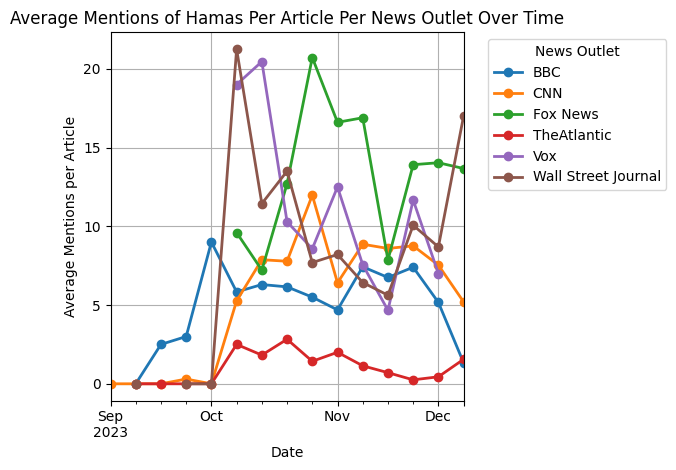

In [ ]:

# Create a line plot of average mentions per news_outlet over time
plt.figure(figsize=(12, 6))
average_mentions_per_outlet_over_time.plot(marker='o', linewidth=2)
plt.title('Average Mentions of Hamas Per Article Per News Outlet Over Time')
plt.xlabel('Date')
plt.ylabel('Average Mentions per Article')
plt.legend(title='News Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

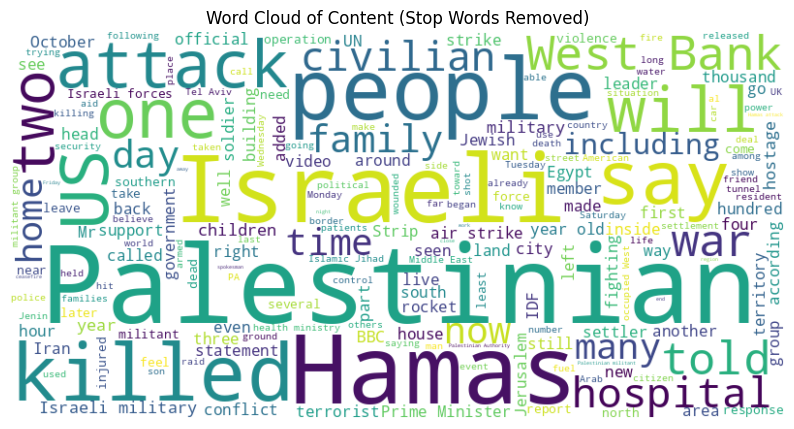

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

bbc_df = df[df['news_outlet'] == 'BBC']
# Assuming df is your DataFrame
# Combine all the text content into a single string
text_content = ' '.join(bbc_df['content'].dropna())

# Define stop words
stop_words = set(STOPWORDS)
stop_words.add('Israel')
stop_words.add('Gaza')
stop_words.add('said')
stop_words.add('s')
stop_words.add('u')
# Generate the word cloud with stop words removed
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(text_content)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Content (Stop Words Removed)')
plt.show()

In [ ]:
news_df = pd.DataFrame(rows)
#rows_to_exclude = [0, 1, 1022, 1147]
#news_df = news_df.drop(rows_to_exclude, axis=0, errors='ignore')
#rows_to_exclude = news_df.loc[news_df['date_published'] == '0000-00-00 00:00:00'].index
# Drop the rows based on the index
#news_df = news_df.drop(rows_to_exclude, axis=0)
news_df

,title,date_published,news_outlet,article_score,confidence_score
0,America Keeps Accidentally Helping Iran,2018-05-09 00:00:00,TheAtlantic,0.1,0.8
1,"'A lot of adrenaline, a lot of unknowns': Rese...",2023-10-10 00:00:00,BBC,0.1,0.8
2,"'As Palestinian youths, the political process ...",2023-06-12 00:00:00,BBC,0.5,0.8
3,'Deeply ashamed.' Another major UPenn backer h...,2023-10-18 00:00:00,CNN,0.0,1.0
4,'Grief and anger.' US business groups stand up...,2023-10-09 00:00:00,CNN,0.0,0.8
...,...,...,...,...,...
2021,You can read Trump’s Israel-Palestine peace pl...,2020-01-28 00:00:00,Vox,0.0,0.8
2022,Your Periodic Reminder That Evil Is Real,2023-10-24 17:49:00,Wall Street Journal,0.0,1.0
2023,Yuval Castleman: Backlash grows over police sh...,2023-12-05 00:00:00,CNN,0.1,0.8
2024,Zelensky Has an Answer for DeSantis,2023-03-20 00:00:00,TheAtlantic,0.0,0.8


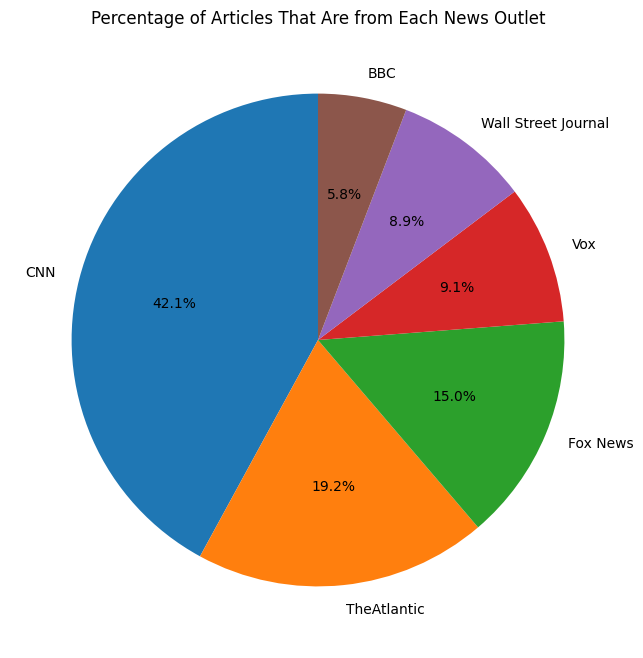

In [ ]:
import matplotlib.pyplot as plt

# Group by news_outlet and count the number of articles for each outlet
outlet_counts = news_df['news_outlet'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(outlet_counts, labels=outlet_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Articles That Are from Each News Outlet')
plt.show()

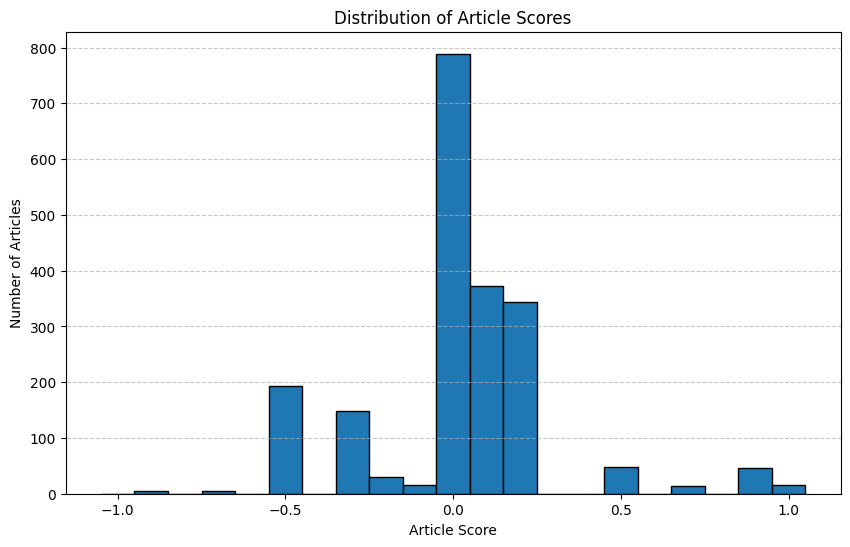

In [ ]:
bin_edges = [-1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25, -0.15, -0.05,
             0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05]

# Plotting a histogram
plt.figure(figsize=(10, 6))
plt.hist(news_df['article_score'], bins=bin_edges, edgecolor='black')
plt.xlabel('Article Score')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
average_scores_df = news_df.groupby('news_outlet')['article_score'].mean().reset_index()
print("Average Article Score by News Outlet:")
print(average_scores_df)

Average Article Score by News Outlet:
           news_outlet  article_score
0                  BBC       0.083051
1                  CNN       0.081338
2             Fox News      -0.125083
3          TheAtlantic       0.013368
4                  Vox       0.045109
5  Wall Street Journal      -0.070000


In [ ]:
import matplotlib.pyplot as plt
news_df['Score_Category'] = pd.cut(news_df['article_score'], bins=[float('-inf'), 0, float('inf')], labels=['Pro-Israeli', 'Pro-Palestinian'])

# Group by 'News_Outlet' and 'Score_Category', calculate the percentage, and pivot the result
percentage_df = news_df.groupby(['news_outlet', 'Score_Category']).size().unstack(fill_value=0)
percentage_df

Score_Category,Pro-Israeli,Pro-Palestinian
news_outlet,,
BBC,30,61
CNN,275,297
Fox News,232,71
TheAtlantic,128,43
Vox,23,34
Wall Street Journal,114,52


In [ ]:
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100
percentage_df


Score_Category,Pro-Israeli,Pro-Palestinian
news_outlet,,
BBC,36.440678,63.559322
CNN,46.126761,53.873239
Fox News,76.567657,23.432343
TheAtlantic,71.979434,28.020566
Vox,60.326087,39.673913
Wall Street Journal,70.000000,30.000000


In [ ]:
percentage_df.reset_index()

Score_Category,news_outlet,Pro-Israeli,Pro-Palestinian
0,BBC,36.440678,63.559322
1,CNN,46.126761,53.873239
2,Fox News,76.567657,23.432343
3,TheAtlantic,71.979434,28.020566
4,Vox,60.326087,39.673913
5,Wall Street Journal,70.000000,30.000000


In [ ]:
import plotly.express as px

In [ ]:
news_df['Score_Category'] = pd.cut(news_df['article_score'], bins=[float('-inf'), 0, float('inf')], labels=['Pro-Israeli', 'Pro-Palestinian'])

# Group by 'News_Outlet' and 'Score_Category', calculate the percentage, and pivot the result
percentage_df = news_df.groupby(['news_outlet', 'Score_Category']).size().unstack(fill_value=0)
percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100
percentage_df = percentage_df.reset_index()

fig = px.bar(
      percentage_df,
      x='news_outlet',
      y=['Pro-Israeli', 'Pro-Palestinian'],
      labels={'value': 'Percentage', 'variable': 'Score Category'},
      title='Percentage of Articles Pro-Israeli Articles by News Outlet',
      color='variable',
      # color_discrete_map={'Pro-Israeli': 'blue', 'Pro-Palestinian': 'red'},
      height=700
  )

  # Customize layout
fig.update_layout(
      yaxis=dict(title='Percentage'),
      xaxis=dict(title='News Outlet'),
      barmode='stack'
  )
fig.show()

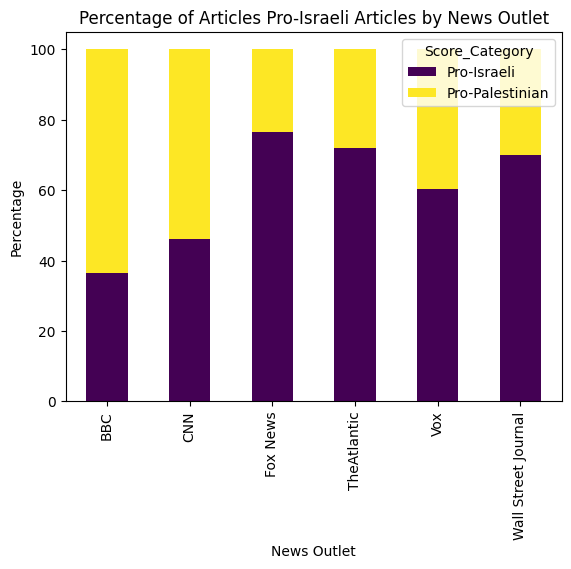

In [ ]:
# Plot the bar chart
ax = percentage_df.plot(kind='bar', stacked=True, colormap='viridis')
ax.set_ylabel('Percentage')
ax.set_xlabel('News Outlet')
ax.set_title('Percentage of Articles Pro-Israeli Articles by News Outlet')

# Display the bar chart
plt.show()

In [ ]:
percentage_article_0 = (
    news_df[news_df['article_score'] == 0]
    .groupby('news_outlet')
    .size()
    .div(news_df.groupby('news_outlet').size())
    .mul(100)
    .reset_index(name='Percentage of Neutral Articles')
)

# Display the resulting DataFrame
print("Percentage of Neutral Articles by News Outlet:")
print(percentage_article_0)

Percentage of Neutral Articles by News Outlet:
           news_outlet  Percentage of Neutral Articles
0                  BBC                       16.949153
1                  CNN                       32.746479
2             Fox News                       25.082508
3          TheAtlantic                       62.210797
4                  Vox                       54.891304
5  Wall Street Journal                       39.444444


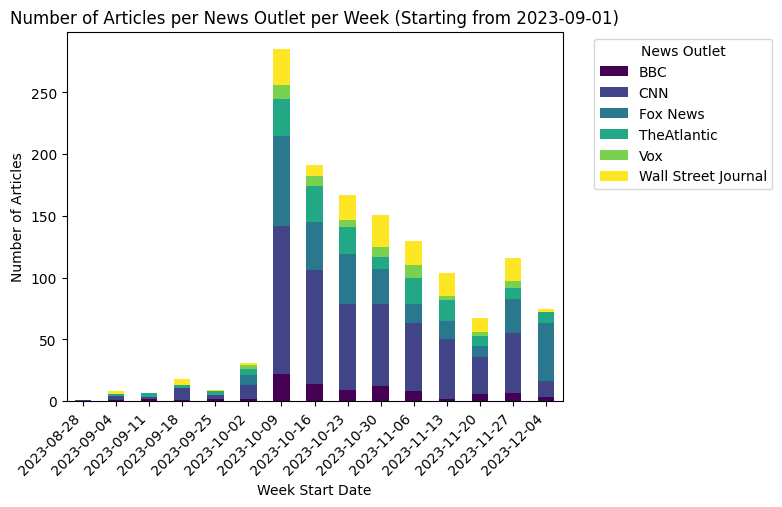

In [ ]:
news_df['date_published'] = pd.to_datetime(news_df['date_published'], errors='coerce')

# Drop rows with NaT (invalid dates)
news_df = news_df.dropna(subset=['date_published'])

news_df = news_df[news_df['date_published'] >= '2023-09-01']

# Extract the week and year from the date
news_df['Week'] = news_df['date_published'].dt.strftime('%Y-%U')

# Group by 'Week' and 'News_Outlet', and count the number of articles
articles_per_week = news_df.groupby(['Week', 'news_outlet']).size().unstack(fill_value=0)

week_start_dates = pd.to_datetime(articles_per_week.index.str.split('-').str[0] + '-W' + articles_per_week.index.str.split('-').str[1] + '-1', format='%Y-W%U-%w')
week_start_dates = week_start_dates.strftime('%Y-%m-%d')

# Plot the number of articles per news_outlet per week
ax = articles_per_week.plot(kind='bar', stacked=True, colormap='viridis')
ax.set_xticklabels(week_start_dates, rotation=45, ha='right')
plt.xlabel('Week Start Date')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per News Outlet per Week (Starting from 2023-09-01)')
plt.legend(title='News Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
news_df['date_published'] = pd.to_datetime(news_df['date_published'], errors='coerce')

# Drop rows with NaT (invalid dates)
news_df = news_df.dropna(subset=['date_published'])

news_df = news_df[news_df['date_published'] >= '2023-09-01']

# Extract the week and year from the date
news_df['Week'] = news_df['date_published'].dt.strftime('%Y-%U')

# Group by 'Week' and 'News_Outlet', and count the number of articles
articles_per_week = news_df.groupby(['Week', 'news_outlet']).size().unstack(fill_value=0)

week_start_dates = pd.to_datetime(articles_per_week.index.str.split('-').str[0]
                                  + '-W'
                                  + articles_per_week.index.str.split('-').str[1]
                                  + '-1', format='%Y-W%U-%w')
week_start_dates = week_start_dates.strftime('%Y-%m-%d')
articles_per_week_long = articles_per_week.reset_index().melt(id_vars='Week', var_name='News_Outlet', value_name='Number_of_Articles')
articles_per_week_long

,Week,News_Outlet,Number_of_Articles
0,2023-35,BBC,0
1,2023-36,BBC,1
2,2023-37,BBC,2
3,2023-38,BBC,1
4,2023-39,BBC,2
...,...,...,...
85,2023-45,Wall Street Journal,20
86,2023-46,Wall Street Journal,19
87,2023-47,Wall Street Journal,11
88,2023-48,Wall Street Journal,19


In [ ]:


# Create an interactive bar chart using Plotly Express
fig = px.bar(
    articles_per_week_long,
    x='Week',
    y='Number_of_Articles',
    color='News_Outlet',
    labels={'Number_of_Articles': 'Number of Articles', 'Week': 'Week Start Date'},
    title='Number of Articles per News Outlet per Week (Starting from 2023-09-01)',
)

# Customize layout
fig.update_layout(
    xaxis=dict(title='Week Start Date',
               tickangle=45,
               tickmode='array',
               tickvals=week_start_dates,
               ticktext=week_start_dates),
    yaxis=dict(title='Number of Articles'),
    legend_title='News Outlet',
)
fig.show()

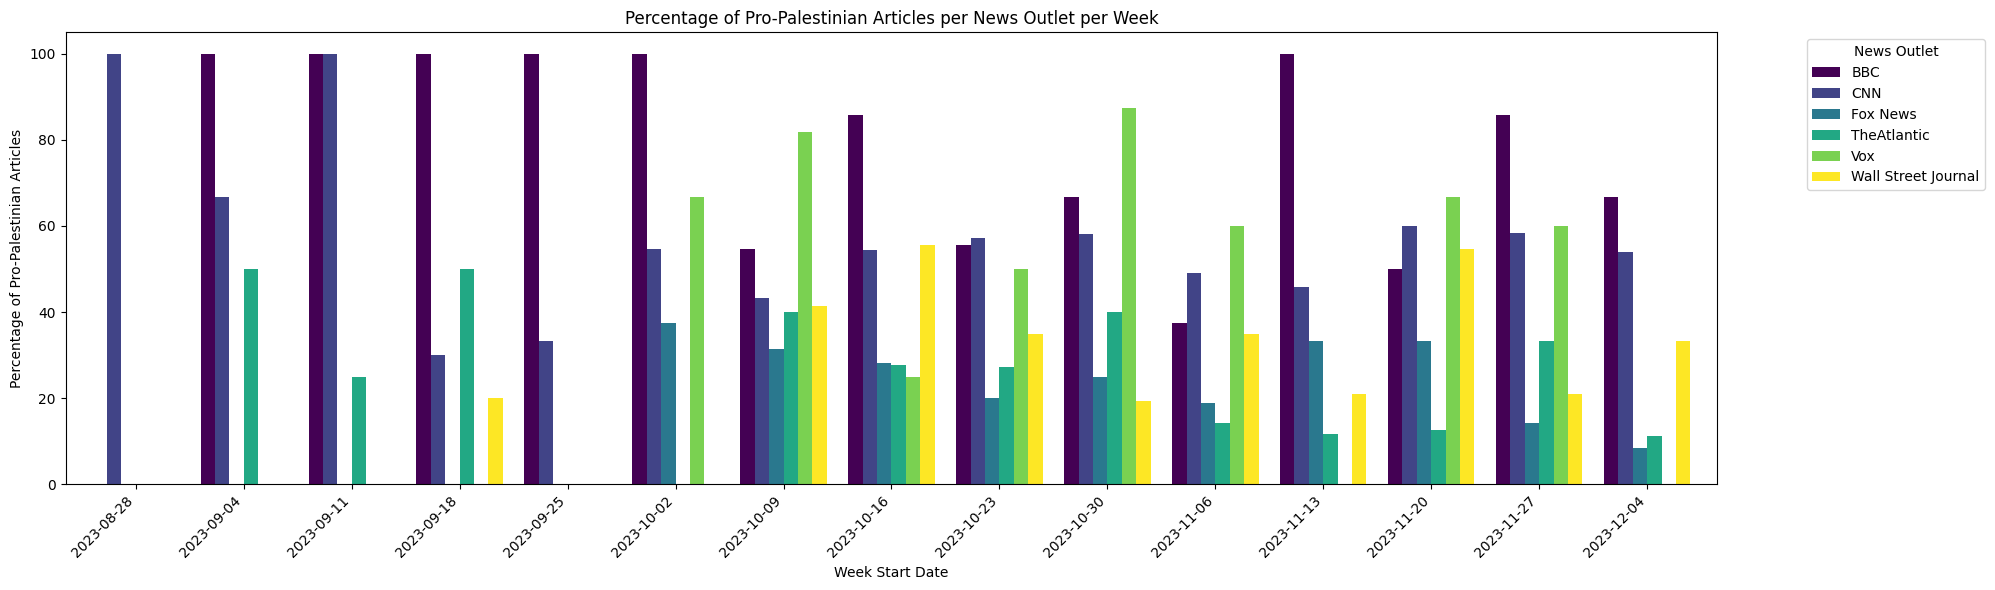

In [ ]:
news_df['date_published'] = pd.to_datetime(news_df['date_published'], errors='coerce')

# Drop rows with NaT (invalid dates)
news_df = news_df.dropna(subset=['date_published'])

news_df = news_df[news_df['date_published'] >= '2023-09-01']

# Extract the week and year from the date
news_df['Week'] = news_df['date_published'].dt.strftime('%Y-%U')

news_df['Score_Category'] = pd.cut(news_df['article_score'], bins=[float('-inf'), 0, float('inf')], labels=['Negative', 'Positive'])

# Group by 'Week', 'News_Outlet', and 'Score_Category', calculate the percentage, and pivot the result
percentage_positive_articles = (
    news_df[news_df['Score_Category'] == 'Positive']
    .groupby(['Week', 'news_outlet'])
    .size()
    .div(news_df.groupby(['Week', 'news_outlet']).size())
    .mul(100)
    .unstack(fill_value=0)
)

# Group by 'Week' and 'News_Outlet', and count the number of articles
articles_per_week = news_df.groupby(['Week', 'news_outlet']).size().unstack(fill_value=0)

week_start_dates = pd.to_datetime(articles_per_week.index.str.split('-').str[0] + '-W' + articles_per_week.index.str.split('-').str[1] + '-1', format='%Y-W%U-%w')
week_start_dates = week_start_dates.strftime('%Y-%m-%d')

bar_width = 0.8
fig, ax = plt.subplots(figsize=(20, 6))

# Plot the number of articles per news_outlet per week
ax = percentage_positive_articles.plot(kind='bar', stacked=False, width=bar_width, colormap='viridis', ax = ax)
ax.set_xticklabels(week_start_dates, rotation=45, ha='right')
plt.xlabel('Week Start Date')
plt.ylabel('Percentage of Pro-Palestinian Articles')
plt.title('Percentage of Pro-Palestinian Articles per News Outlet per Week')
plt.legend(title='News Outlet', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
news_df

,title,date_published,news_outlet,article_score,confidence_score,Week,Score_Category,bias
1,"'A lot of adrenaline, a lot of unknowns': Rese...",2023-10-10 00:00:00,BBC,0.1,0.8,2023-41,Positive,Center
3,'Deeply ashamed.' Another major UPenn backer h...,2023-10-18 00:00:00,CNN,0.0,1.0,2023-42,Negative,Left
4,'Grief and anger.' US business groups stand up...,2023-10-09 00:00:00,CNN,0.0,0.8,2023-41,Negative,Left
5,'I simply don’t want to die at 24' - Gaza woma...,2023-11-01 00:00:00,BBC,0.7,0.9,2023-44,Positive,Center
6,'I wake up and check if my family in Gaza is s...,2023-10-13 00:00:00,BBC,0.7,0.9,2023-41,Positive,Center
...,...,...,...,...,...,...,...,...
2018,"Yes, the U.S. Can Afford to Help Its Allies",2023-10-20 00:00:00,TheAtlantic,0.0,1.0,2023-42,Negative,NaN
2020,"Yoon warns South Korea, United States must be ...",2023-11-12 00:00:00,Fox News,0.0,1.0,2023-46,Negative,Right
2022,Your Periodic Reminder That Evil Is Real,2023-10-24 17:49:00,Wall Street Journal,0.0,1.0,2023-43,Negative,Right
2023,Yuval Castleman: Backlash grows over police sh...,2023-12-05 00:00:00,CNN,0.1,0.8,2023-49,Positive,Left


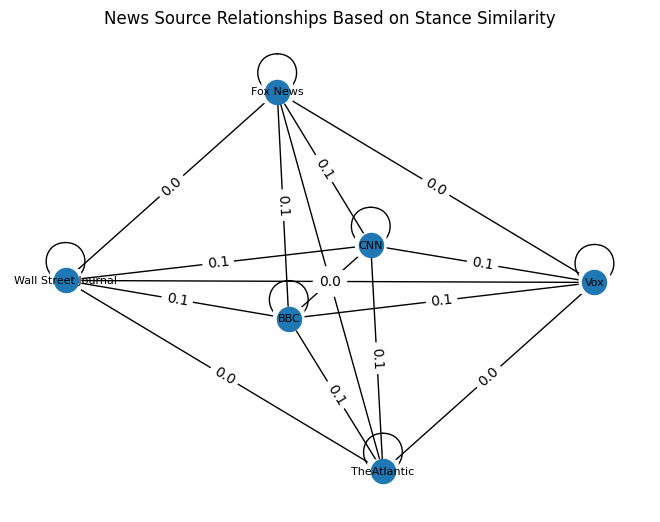

In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

bias_mapping = {
    'Vox': 'Left',
    'CNN': 'Center',
    'BBC': 'Center',
    'Wall Street Journal': 'Right',
    'Fox News': 'Right',
    'TheAtlantic': 'Left'
}

# Add a new 'bias' column based on the 'news_outlet' column
news_df['bias'] = news_df['news_outlet'].map(bias_mapping)
news_df['article_score'] = pd.to_numeric(news_df['article_score'], errors='coerce')

# Create a graph
G = nx.Graph()

# Add nodes for each news source
for index, row in news_df.iterrows():
    G.add_node(row['news_outlet'], bias=row['bias'], stance=row['article_score'])

# Add edges based on similarities (you can define your own similarity metric)
for source1, source2 in combinations(news_df['news_outlet'], 2):
    bias_similarity = abs(G.nodes[source1]['stance'] - G.nodes[source2]['stance'])
    G.add_edge(source1, source2, weight=bias_similarity)

# Draw the network graph
pos = nx.spring_layout(G)  # You can choose a different layout
labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, font_size=8, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title('News Source Relationships Based on Stance Similarity')
plt.show()


In [ ]:
news_df.groupby('news_outlet').mean()

<ipython-input-24-1b0ab3ef8e50>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,article_score,confidence_score
news_outlet,,
BBC,0.115385,0.829670
CNN,0.085839,0.866608
Fox News,-0.125083,0.844884
TheAtlantic,0.002924,0.911111
Vox,0.077193,0.863158
Wall Street Journal,-0.075301,0.864458


In [ ]:
average_scores = news_df.groupby('news_outlet')['article_score'].mean().reset_index()
average_scores['bias'] = average_scores['news_outlet'].map(bias_mapping)
average_scores

,news_outlet,article_score,bias
0,BBC,0.115385,Center
1,CNN,0.085839,Center
2,Fox News,-0.125083,Right
3,TheAtlantic,0.002924,Left
4,Vox,0.077193,Left
5,Wall Street Journal,-0.075301,Right


In [ ]:
fig = px.scatter(
    average_scores,
    x='bias',
    y='article_score',
    text='news_outlet',  # Display news outlet names on hover
    color='bias',
    color_discrete_map={'Left': 'blue', 'Center': 'grey', 'Right': 'red'},
    size_max=30,  # Adjust the maximum bubble size
    labels={'article_score': 'Average Sentiment Score', 'bias': 'Political Bias'},
    title='Average Sentiment Scores by Political Bias',
    height=500
)

# Customize layout
fig.update_layout(
    yaxis=dict(title='Average Sentiment Score'),
    xaxis=dict(title='Political Bias'),
)

# Show the interactive plot
fig.show()

In [ ]:
counts

,index,news_outlet
0,CNN,572
1,Fox News,303
2,TheAtlantic,171
3,Wall Street Journal,166
4,BBC,91
5,Vox,57


In [ ]:
average_scores

,news_outlet,article_score
0,BBC,0.115385
1,CNN,0.085839
2,Fox News,-0.125083
3,TheAtlantic,0.002924
4,Vox,0.077193
5,Wall Street Journal,-0.075301


In [ ]:
counts = pd.DataFrame(news_df['news_outlet'].value_counts().reset_index())
counts.columns = ['news_outlet', 'num']
average_scores = news_df.groupby('news_outlet')['article_score'].mean().reset_index()

# Merge the two DataFrames on 'news_outlet'
summary_df = pd.merge(counts, average_scores, on='news_outlet', how='inner')

# Rename columns for clarity
summary_df.columns = ['news_outlet', 'num_articles', 'average_score']

# Add bias information
summary_df['bias'] = summary_df['news_outlet'].map(bias_mapping)

summary_df

,news_outlet,num_articles,average_score,bias
0,CNN,572,0.085839,Center
1,Fox News,303,-0.125083,Right
2,TheAtlantic,171,0.002924,Left
3,Wall Street Journal,166,-0.075301,Right
4,BBC,91,0.115385,Center
5,Vox,57,0.077193,Left


In [ ]:
scaling_factor = 0.05
x_category_order = ['Right', 'Center', 'Left']
fig = px.scatter(
    summary_df,
    x='bias',
    y='average_score',
    size='num_articles',
    size_max=summary_df['num_articles'].max() * scaling_factor,
    text='news_outlet',
    labels={'average_score': 'Average Sentiment Score', 'num_articles': 'Number of Articles', 'bias': 'Bias'},
    title='Average Sentiment Scores and Number of Articles per News Outlet',
    color='bias',
    color_discrete_map={'Left': 'blue', 'Center': 'grey', 'Right': 'red'},
    height=500
)
fig.update_layout(
    xaxis=dict(title='Bias', categoryorder='array', categoryarray=x_category_order),
    yaxis=dict(title='Average Sentiment Score'),
    showlegend=False
)

# Show the interactive plot
fig.show()